First, mount your Google Drive by running the following cell. You'll be prompted to authorize access to your Google Drive account.

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Once your Drive is mounted, you can access files. Here's an example of how to load a CSV file named `my_data.csv` located in the root of 'My Drive' into a pandas DataFrame. You'll need to replace `my_data.csv` with the actual path to your file.

In [10]:
# runtime: Python 3, GPU (set in Colab: Runtime → Change runtime type → GPU)
!nvidia-smi
#!pip install -q ultralytics==8.0.149  # or latest stable
!pip install -q roboflow  


Wed Nov 26 14:36:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [11]:
import os, textwrap, yaml


DATASET_PATH = "/content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/dataset"


CLASS_NAMES = ['good','scratch','dent']  

# Create data.yaml for YOLOv8
data = {
    'path': DATASET_PATH,
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'names': CLASS_NAMES
}

os.makedirs(DATASET_PATH, exist_ok=True)
with open(os.path.join(DATASET_PATH, 'data.yaml'), 'w') as f:
    yaml.dump(data, f)

print("Wrote data.yaml to", os.path.join(DATASET_PATH, 'data.yaml'))
print("---")
print(open(os.path.join(DATASET_PATH, 'data.yaml')).read())


Wrote data.yaml to /content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/dataset/data.yaml
---
names:
- good
- scratch
- dent
path: /content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/dataset
test: images/test
train: images/train
val: images/val



In [12]:
import glob, os
for split in ['train','val','test']:
    imgs = glob.glob(os.path.join(DATASET_PATH, 'images', split, '*'))
    lbls = glob.glob(os.path.join(DATASET_PATH, 'labels', split, '*'))
    print(f"{split}: images={len(imgs)}, labels={len(lbls)}")

# show any images without matching label (for negative samples leave label absent or empty)
missing_lbl = []
for img in glob.glob(os.path.join(DATASET_PATH, 'images', 'train', '*')):
    base = os.path.splitext(os.path.basename(img))[0]
    if not os.path.exists(os.path.join(DATASET_PATH, 'labels', 'train', base + '.txt')):
        missing_lbl.append(base)
print("Some training images missing label files (okay if they are negative samples):", len(missing_lbl))


train: images=240, labels=178
val: images=30, labels=20
test: images=30, labels=21
Some training images missing label files (okay if they are negative samples): 78


In [18]:
print(f"Listing contents of DATASET_PATH: {DATASET_PATH}")
!ls -R "{DATASET_PATH}" || echo "Directory not found or accessible: {DATASET_PATH}"


Listing contents of DATASET_PATH: /content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/dataset
/content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/dataset:
classes.txt  data.yaml	labels	      split_dataset.py
dataset_raw  images	metadata.csv  verify_labels.py

/content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/dataset/dataset_raw:

/content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/dataset/images:
test  train  val

/content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/dataset/images/test:
gear_dent_Gear_dent_11.png  gear_good_gear_gud_64.png
gear_den

Please examine the output above carefully. Look for `images/train`, `images/val`, `images/test`, `labels/train`, `labels/val`, and `labels/test` directories directly under the `DATASET_PATH`. If the images and labels are nested deeper, or named differently, that would explain why the previous script found nothing. Once we see the actual structure, we can adjust the `data.yaml` or the `DATASET_PATH` variable accordingly.

First, let's load the trained model. We'll use the `best.pt` weights generated during your training run, which are typically found in the `weights` subdirectory of your experiment's run folder.

Now, let's classify a sample image. I'll pick an image from your test set. The model will output bounding boxes and class predictions for any detected defects.

In [14]:
import random, os
train_imgs = os.listdir(os.path.join(DATASET_PATH, 'images', 'train'))
sample = random.sample(train_imgs, min(5, len(train_imgs)))
for s in sample:
    base = os.path.splitext(s)[0]
    lbl_path = os.path.join(DATASET_PATH, 'labels', 'train', base + '.txt')
    print(s, "->", "label exists" if os.path.exists(lbl_path) else "no label")
    if os.path.exists(lbl_path):
        print("  ", open(lbl_path).read().strip())


gear_good_gear_gud_10.png -> label exists
   
gear_dent_Gear_dent_97.png -> label exists
   2 0.647278 0.551461 0.031320 0.058450
gear_voids_Gear_void_4.png -> no label
gear_voids_Gear_void_45.png -> no label
gear_good_gear_gud_21.png -> label exists
   


In [15]:
# upgrade ultralytics
!pip install -U ultralytics

# ensure a compatible torch is installed (Colab usually already has a GPU-friendly torch)

!pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 76.9 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cu118


In [16]:
# show if a local file exists
!ls -l yolov8s.pt || true
# if it exists, remove it so the CLI downloads the correct hub weights
!rm -f yolov8s.pt


ls: cannot access 'yolov8s.pt': No such file or directory


In [28]:
# Parameters 
MODEL="yolov8s.pt"   # (yolov8n / s / m / l). 
EPOCHS=40
IMGSZ=640
BATCH=16            # reduce if GPU OOM
WORKDIR="/content/runs"   # where results will be stored
weights_only="True"
# Train using ultralytics 'yolo' CLI
!yolo detect train data="{DATASET_PATH}/data.yaml" model={MODEL} epochs={EPOCHS} imgsz={IMGSZ} batch={BATCH} project={WORKDIR} name="yolo_train_noaug" exist_ok=True


Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_trai

In [29]:
from ultralytics import YOLO
import os

# Path to the best trained model weights
model_path = os.path.join(WORKDIR, 'yolo_train_noaug', 'weights', 'best.pt')

# Load a custom model
model = YOLO(model_path)

print(f"Model loaded from: {model_path}")


Model loaded from: /content/runs/yolo_train_noaug/weights/best.pt


Classifying image: /content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/dataset/images/test/gear_dent_Gear_dent_96.png

image 1/1 /content/drive/MyDrive/case_study_intelligent_system/project_casestudy/Integration-and-Comparison-of-vision-models-for-smart-inspection-cell/dataset/images/test/gear_dent_Gear_dent_96.png: 384x640 1 dent, 11.0ms
Speed: 2.1ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


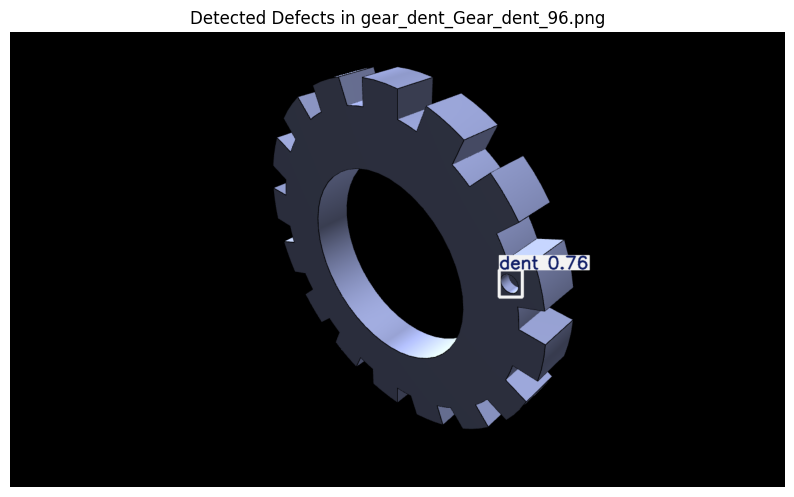

Detected defects:
- dent (Confidence: 0.76)


In [33]:
from PIL import Image
import matplotlib.pyplot as plt

# Example image path from test set
image_to_classify_path = os.path.join(DATASET_PATH, 'images', 'test', 'gear_dent_Gear_dent_96.png')

print(f"Classifying image: {image_to_classify_path}")

# Run inference on the image
results = model(image_to_classify_path)

# Process results
for r in results:
    # Plot results on the image
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image

    # Display the image with predictions
    plt.figure(figsize=(10, 10))
    plt.imshow(im)
    plt.axis('off')
    plt.title(f"Detected Defects in {os.path.basename(image_to_classify_path)}")
    plt.show()

    # Print detected classes and confidence scores
    if len(r.boxes) == 0:
        print("No defects detected.")
    else:
        print("Detected defects:")
        for box in r.boxes:
            class_id = int(box.cls[0])
            conf = box.conf[0]
            defect_name = CLASS_NAMES[class_id] # Assuming CLASS_NAMES is defined from data.yaml
            print(f"- {defect_name} (Confidence: {conf:.2f})")


Available metrics in results.csv: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


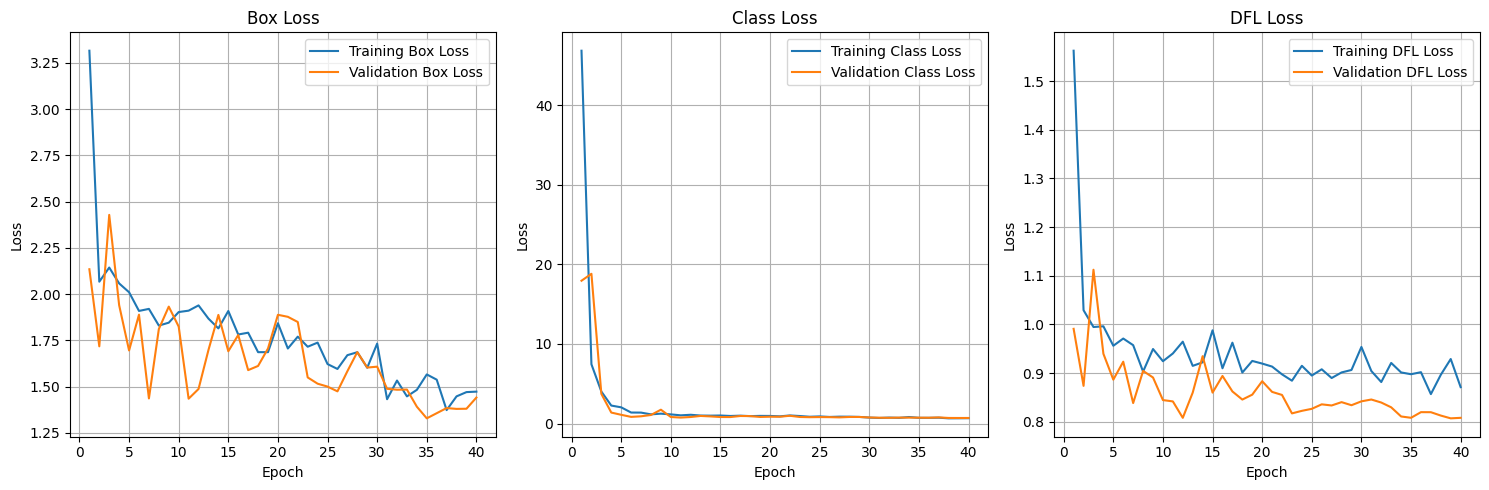

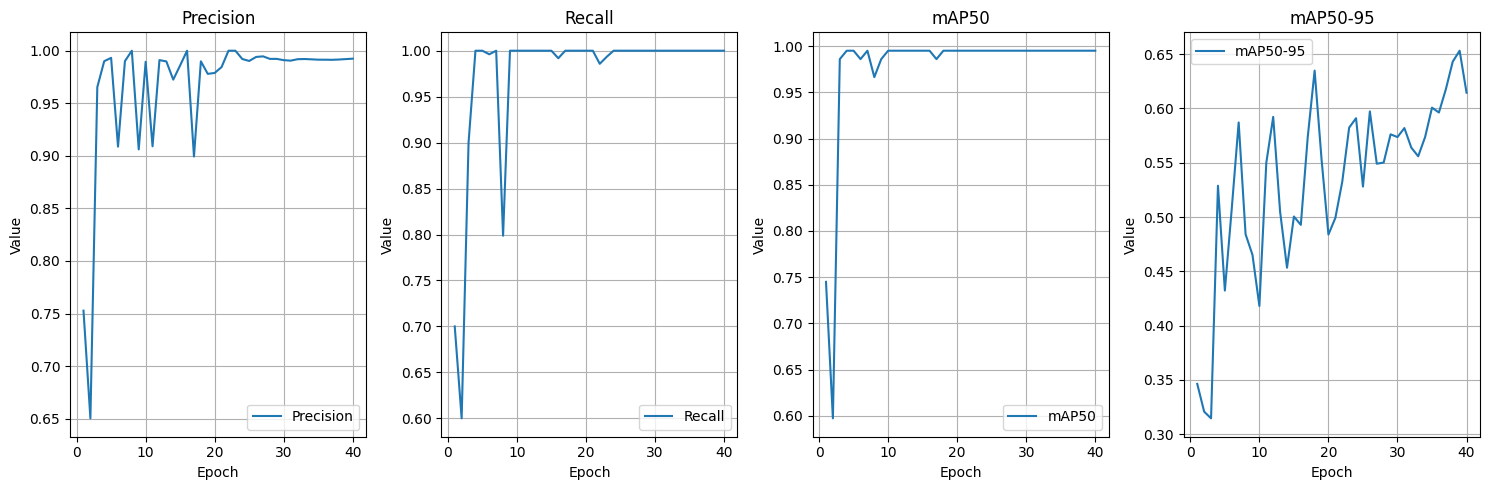

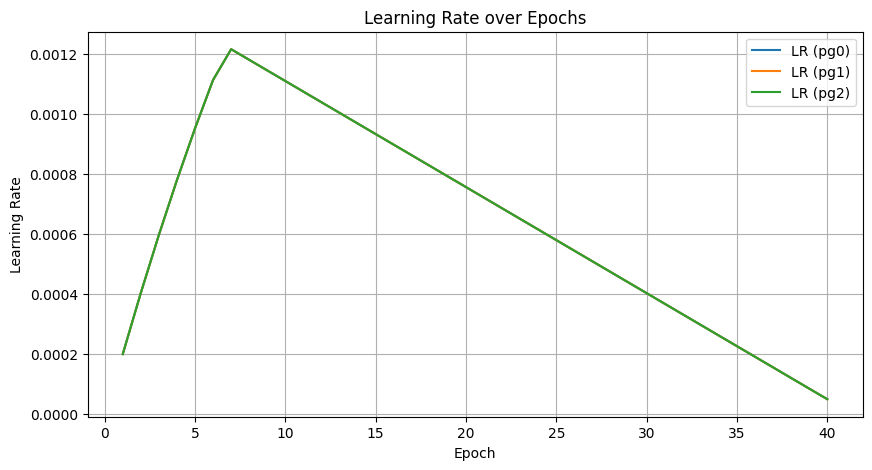

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Construct the path to the results.csv file
results_path = os.path.join(WORKDIR, 'yolo_train_noaug', 'results.csv')

# Check if the results.csv file exists
if not os.path.exists(results_path):
    print(f"Error: results.csv not found at {results_path}")
else:
    # Read the results.csv file into a pandas DataFrame
    try:
        results_df = pd.read_csv(results_path, sep=',')
    except Exception:
        results_df = pd.read_csv(results_path, sep=' ')

    # Display columns to confirm available metrics
    print("Available metrics in results.csv:", results_df.columns.tolist())

    # Plotting Loss Metrics
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(results_df['epoch'], results_df['train/box_loss'], label='Training Box Loss')
    plt.plot(results_df['epoch'], results_df['val/box_loss'], label='Validation Box Loss')
    plt.title('Box Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(results_df['epoch'], results_df['train/cls_loss'], label='Training Class Loss')
    plt.plot(results_df['epoch'], results_df['val/cls_loss'], label='Validation Class Loss')
    plt.title('Class Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(results_df['epoch'], results_df['train/dfl_loss'], label='Training DFL Loss')
    plt.plot(results_df['epoch'], results_df['val/dfl_loss'], label='Validation DFL Loss')
    plt.title('DFL Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plotting Accuracy/Performance Metrics
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.plot(results_df['epoch'], results_df['metrics/precision(B)'], label='Precision')
    plt.title('Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 4, 2)
    plt.plot(results_df['epoch'], results_df['metrics/recall(B)'], label='Recall')
    plt.title('Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 4, 3)
    plt.plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='mAP50')
    plt.title('mAP50')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 4, 4)
    plt.plot(results_df['epoch'], results_df['metrics/mAP50-95(B)'], label='mAP50-95')
    plt.title('mAP50-95')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plotting Learning Rate
    plt.figure(figsize=(10, 5))
    plt.plot(results_df['epoch'], results_df['lr/pg0'], label='LR (pg0)')
    plt.plot(results_df['epoch'], results_df['lr/pg1'], label='LR (pg1)')
    plt.plot(results_df['epoch'], results_df['lr/pg2'], label='LR (pg2)')
    plt.title('Learning Rate over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.grid(True)
    plt.show()